<a href="https://colab.research.google.com/github/pdoren/Machine-Learning-G105/blob/main/Desaf%C3%ADo_Predicci%C3%B3n_de_renuncia_de_clientes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafío - Predicción de renuncia de clientes

**Nombre**: Pablo Saavedra <br />
**Curso**: Modelos avanzados y Redes Neuronales (G105)


---

### Importación de librerías

In [49]:
from __future__ import annotations

# --- Standard library ---
from typing import Any, Dict, Iterable, Optional

# --- Third-party ---
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs, make_circles

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import SGD # Gradiente Descendente estocástico

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from tensorflow.keras.metrics import AUC

# --- Pandas display options ---
pd.options.display.float_format = "{:,.2f}".format


### Funciones útiles

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, matthews_corrcoef
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay


def plot_hist(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3, _bins='auto', _title=""):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))
  axes = axes.flatten()  # Para iterar fácil

  for i, col in enumerate(_num_cols):
      sns.histplot(data=_df[col], kde=False, stat='density', ax=axes[i], bins=_bins)
      sns.kdeplot(data=_df[col], color='tomato', lw=3, ax=axes[i])
      axes[i].set_title(f"Distribución de {col} {_title}")

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

def plot_outliers(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))

  if isinstance(axes, np.ndarray):
      axes = axes.ravel()
  else:
      axes = np.array([axes])

  for i, col in enumerate(_num_cols):
      sns.boxplot(x=_df[col], flierprops = {'markerfacecolor':'tomato', 'marker':'D'}, ax=axes[i])
      axes[i].set_title(f"Outliers en {col}")
      axes[i].set_xlabel(col)

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


def clean_outliers(_df: pd.DataFrame, _cols: list, _k: float=1.5):
  df_ret = _df.copy()
  for col in _cols:
    while True:
      q1, q3 = df_ret[col].quantile([.25, .75])
      iqr = q3 - q1
      low, high = q1 - _k * iqr, q3 + _k * iqr
      mask_out = (df_ret[col] < low) | (df_ret[col] > high)
      if mask_out.any():
        df_ret = df_ret[~mask_out]
      else:
        break
  return df_ret

def clean_outliers_percentiles(
    _df: pd.DataFrame,
    _cols: list,
    p_low: float = 1,     # percentil inferior
    p_high: float = 99    # percentil superior
):

    df_ret = _df.copy()

    for col in _cols:
        # Calcular umbrales por percentiles
        low = df_ret[col].quantile(p_low / 100)
        high = df_ret[col].quantile(p_high / 100)

        # Crear máscara de puntos válidos
        mask = (df_ret[col] >= low) & (df_ret[col] <= high)

        # Filtrar el DataFrame
        df_ret = df_ret[mask]

    return df_ret

def plot_count(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3, _X:str=None):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))
  axes = axes.flatten()  # Para iterar fácil

  if _X is not None:
    for i, col in enumerate(_num_cols):
        sns.countplot(x=_X, data=_df, ax=axes[i], hue=str(col))
        axes[i].set_title(f"Frecuencia de {col}")
  else:
    for i, col in enumerate(_num_cols):
        sns.countplot(y=col, data=_df, order=_df[col].value_counts().index, ax=axes[i], hue=str(col))
        axes[i].set_title(f"Frecuencia de {col}")

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


def eval_model(
  model,
  X_train, y_train,
  X_test,  y_test,
  class_names: Optional[Iterable[str]] = None,
  *,
  normalize_cm: str | None = "true",   # "true" | "pred" | "all" | None
  average: str = "weighted",           # "macro" | "weighted" | "micro"
  plot: bool = True,
  title_prefix: str = "",
  binary_threshold: Optional[float] = None,  # si None y hay proba, usa 0.5
  zero_division: int = 0,
  label_map: Optional[Dict[Any, int]] = None # parche: {'No':0,'Yes':1}, etc.
) -> Dict[str, Any]:
  """
  Evalúa un clasificador en train/test con métricas y (opcional) gráficos.
  Incluye parche para alinear tipos de etiqueta (p. ej., y_true en str y y_pred en int).
  Retorna un diccionario con métricas.

  Parámetros clave:
  - class_names: etiquetas para los ejes de las matrices de confusión.
  - label_map: mapeo explícito de etiquetas reales -> enteros del modelo.
  - binary_threshold: umbral de decisión si el modelo expone predict_proba/decision_function.
  """
  # ---------------------------
  # 0) Parche de etiquetas
  # ---------------------------
  y_train = np.asarray(y_train)
  y_test  = np.asarray(y_test)

  # ¿El modelo genera probabilidades / scores?
  has_proba    = hasattr(model, "predict_proba")
  has_decision = hasattr(model, "decision_function")

  # Predicciones "crudas"
  y_pred_train = model.predict(X_train)
  y_pred_test  = model.predict(X_test)

  # Detecta tipo de problema (binario/multiclase)
  target_kind = type_of_target(y_test)
  is_binary = target_kind == "binary"

  # Si viene un mapeo explícito, aplícalo a y_* reales
  if label_map is not None:
      y_train = np.vectorize(label_map.get)(y_train)
      y_test  = np.vectorize(label_map.get)(y_test)

  # Si aún hay choque de tipos (str vs int), intenta auto-mapeo seguro para binario
  def _needs_alignment(y_true, y_pred):
      return (np.asarray(y_true).dtype.kind in "OUS") and (np.asarray(y_pred).dtype.kind in "iu")

  if _needs_alignment(y_test, y_pred_test):
      if not is_binary:
          raise TypeError(
              "Las etiquetas verdaderas son strings y las predicciones enteros, y el problema no es binario. "
              "Pasa 'label_map' o entrena el modelo con etiquetas codificadas (LabelEncoder)."
          )
      # Caso binario: preferimos usar class_names si fue entregado con orden [neg, pos]
      if class_names is not None and len(list(class_names)) == 2:
          auto_map = {class_names[0]: 0, class_names[1]: 1}
          y_train = np.vectorize(auto_map.get)(y_train)
          y_test  = np.vectorize(auto_map.get)(y_test)
      else:
          # Intento de usar el orden natural de las clases observadas (no 100% seguro)
          uniq = list(np.unique(y_train))
          if len(uniq) == 2 and set(np.unique(y_pred_test)) <= {0, 1}:
              auto_map = {uniq[0]: 0, uniq[1]: 1}
              y_train = np.vectorize(auto_map.get)(y_train)
              y_test  = np.vectorize(auto_map.get)(y_test)
          else:
              raise TypeError(
                  "No se pudo alinear automáticamente y_true (strings) con y_pred (0/1). "
                  "Proporciona class_names=['No','Sí'] o label_map={'No':0,'Sí':1}."
              )

  # ---------------------------
  # 1) Umbral binario (si aplica)
  # ---------------------------
  proba_train = proba_test = None
  pos_scores_train = pos_scores_test = None

  if is_binary and (has_proba or has_decision):
      if has_proba:
          proba_train = model.predict_proba(X_train)
          proba_test  = model.predict_proba(X_test)
          pos_scores_train = proba_train[:, 1]
          pos_scores_test  = proba_test[:, 1]
      else:
          # decision_function
          pos_scores_train = model.decision_function(X_train)
          pos_scores_test  = model.decision_function(X_test)

      thr = 0.5 if binary_threshold is None else float(binary_threshold)
      y_pred_train = (pos_scores_train >= thr).astype(int)
      y_pred_test  = (pos_scores_test  >= thr).astype(int)

  # ---------------------------
  # 2) Métricas numéricas
  # ---------------------------
  metrics: Dict[str, Any] = {}

  def block_metrics(y_true, y_pred, split: str) -> Dict[str, float]:
      acc  = accuracy_score(y_true, y_pred)
      bacc = balanced_accuracy_score(y_true, y_pred)
      p, r, f1, _ = precision_recall_fscore_support(
          y_true, y_pred, average=average, zero_division=zero_division
      )
      mcc = matthews_corrcoef(y_true, y_pred)
      return {
          f"{split}_accuracy": acc,
          f"{split}_balanced_accuracy": bacc,
          f"{split}_precision_{average}": p,
          f"{split}_recall_{average}": r,
          f"{split}_f1_{average}": f1,
          f"{split}_mcc": mcc
      }

  metrics.update(block_metrics(y_train, y_pred_train, "train"))
  metrics.update(block_metrics(y_test,  y_pred_test,  "test"))

  # AUCs si tenemos scores
  if is_binary and (pos_scores_test is not None):
      try:
          metrics["train_roc_auc"] = roc_auc_score(y_train, pos_scores_train)
          metrics["test_roc_auc"]  = roc_auc_score(y_test,  pos_scores_test)
          metrics["train_pr_auc"]  = average_precision_score(y_train, pos_scores_train)
          metrics["test_pr_auc"]   = average_precision_score(y_test,  pos_scores_test)
      except Exception:
          pass

  # ---------------------------
  # 3) Reportes por clase (texto)
  # ---------------------------
  prefix = (title_prefix + " ") if title_prefix else ""
  print(prefix + "Reporte de clasificación (train):")
  print(classification_report(y_train, y_pred_train, digits=3, zero_division=zero_division))
  print(prefix + "Reporte de clasificación (test):")
  print(classification_report(y_test,  y_pred_test,  digits=3, zero_division=zero_division))

  # ---------------------------
  # 4) Gráficos
  # ---------------------------
  if plot:
      # Matrices de confusión
      fig, axes = plt.subplots(2, 2, figsize=(10, 8)) if is_binary and (pos_scores_test is not None) else plt.subplots(1, 2, figsize=(10, 4))
      axes = axes.flatten()

      ConfusionMatrixDisplay.from_predictions(
          y_true=y_train, y_pred=y_pred_train,
          display_labels=class_names, normalize=normalize_cm, ax=axes[0]
      )
      axes[0].set_title(f"{title_prefix} Confusión (train)")

      ConfusionMatrixDisplay.from_predictions(
          y_true=y_test, y_pred=y_pred_test,
          display_labels=class_names, normalize=normalize_cm, ax=axes[1]
      )
      axes[1].set_title(f"{title_prefix} Confusión (test)")

      # Curvas ROC y PR (binario con scores)
      if is_binary and (pos_scores_test is not None):
          RocCurveDisplay.from_predictions(y_test, pos_scores_test, ax=axes[2])
          axes[2].set_title(f"{title_prefix} ROC (test)")

          PrecisionRecallDisplay.from_predictions(y_test, pos_scores_test, ax=axes[3])
          axes[3].set_title(f"{title_prefix} Precision-Recall (test)")

      plt.tight_layout(); plt.show()

  return metrics


def eval_model_short(name, model):
  y_pred = model.predict(X_test)
  # Para AUC necesitamos probas de clase 1
  y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

  print(f"{name:>18} | ACC={acc:.3f} | F1={f1:.3f} | AUC={auc:.3f}")


def plot_corr(
    df,
    method="pearson",
    figsize=(12, 10),
    annot=False,
    cmap="coolwarm",
    vmin=-1,
    vmax=1
):
    """
    Muestra un heatmap de la matriz de correlación de un DataFrame.

    Parámetros
    ----------
    df : pandas.DataFrame
        DataFrame de entrada
    method : str
        Método de correlación: 'pearson', 'spearman', 'kendall'
    figsize : tuple
        Tamaño de la figura
    annot : bool
        Mostrar valores numéricos en el heatmap
    cmap : str
        Colormap
    vmin, vmax : float
        Límites de la escala de correlación
    """

    # Seleccionar solo columnas numéricas
    df_num = df.select_dtypes(include="number")

    if df_num.shape[1] < 2:
        raise ValueError("Se requieren al menos dos columnas numéricas.")

    # Calcular correlación
    corr = df_num.corr(method=method)

    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr,
        annot=annot,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8}
    )

    plt.title(f"Matriz de correlación ({method})", fontsize=14)
    plt.tight_layout()
    plt.show()

In [4]:
from typing import Optional, Iterable, Dict, Any
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_recall_fscore_support,
    matthews_corrcoef,
    roc_auc_score,
    average_precision_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)

def eval_model_preds(
    X_train, y_train,
    X_test,  y_test,
    y_pred_train,
    y_pred_test,
    class_names: Optional[Iterable[str]] = None,
    *,
    normalize_cm: str | None = "true",   # "true" | "pred" | "all" | None
    average: str = "weighted",           # "macro" | "weighted" | "micro"
    plot: bool = True,
    title_prefix: str = "",
    # scores para binario (p.ej. proba[:,1] o decision_function)
    pos_scores_train: Optional[np.ndarray] = None,
    pos_scores_test: Optional[np.ndarray] = None,
    binary_threshold: Optional[float] = None,  # si no None y hay scores, recalcula y_pred
    zero_division: int = 0,
    label_map: Optional[Dict[Any, int]] = None # parche: {'No':0,'Yes':1}, etc.
) -> Dict[str, Any]:
    """
    Evalúa un clasificador en train/test con métricas y (opcional) gráficos,
    recibiendo predicciones ya calculadas (sin pasar el modelo).

    - y_pred_train/y_pred_test: predicción final (clase).
    - pos_scores_* (opcional): scores de clase positiva para AUC/ROC/PR (binario).
    """

    # ---------------------------
    # 0) Preparación / tipos
    # ---------------------------
    y_train = np.asarray(y_train)
    y_test  = np.asarray(y_test)
    y_pred_train = np.asarray(y_pred_train)
    y_pred_test  = np.asarray(y_pred_test)

    target_kind = type_of_target(y_test)
    is_binary = target_kind == "binary"

    # Si viene un mapeo explícito, aplícalo a y_* reales
    if label_map is not None:
        y_train = np.vectorize(label_map.get)(y_train)
        y_test  = np.vectorize(label_map.get)(y_test)

    # Si hay choque de tipos (str vs int), intenta auto-mapeo seguro para binario
    def _needs_alignment(y_true, y_pred):
        return (np.asarray(y_true).dtype.kind in "OUS") and (np.asarray(y_pred).dtype.kind in "iu")

    if _needs_alignment(y_test, y_pred_test):
        if not is_binary:
            raise TypeError(
                "Las etiquetas verdaderas son strings y las predicciones enteros, y el problema no es binario. "
                "Pasa 'label_map' o codifica etiquetas (LabelEncoder)."
            )
        if class_names is not None and len(list(class_names)) == 2:
            auto_map = {list(class_names)[0]: 0, list(class_names)[1]: 1}
            y_train = np.vectorize(auto_map.get)(y_train)
            y_test  = np.vectorize(auto_map.get)(y_test)
        else:
            uniq = list(np.unique(y_train))
            if len(uniq) == 2 and set(np.unique(y_pred_test)) <= {0, 1}:
                auto_map = {uniq[0]: 0, uniq[1]: 1}
                y_train = np.vectorize(auto_map.get)(y_train)
                y_test  = np.vectorize(auto_map.get)(y_test)
            else:
                raise TypeError(
                    "No se pudo alinear automáticamente y_true (strings) con y_pred (0/1). "
                    "Proporciona class_names=['No','Sí'] o label_map={'No':0,'Sí':1}."
                )

    # ---------------------------
    # 1) Umbral binario (si aplica) usando scores
    # ---------------------------
    if is_binary and (pos_scores_train is not None or pos_scores_test is not None) and (binary_threshold is not None):
        thr = float(binary_threshold)
        if pos_scores_train is not None:
            y_pred_train = (np.asarray(pos_scores_train) >= thr).astype(int)
        if pos_scores_test is not None:
            y_pred_test  = (np.asarray(pos_scores_test)  >= thr).astype(int)

    # ---------------------------
    # 2) Métricas numéricas
    # ---------------------------
    metrics: Dict[str, Any] = {}

    def block_metrics(y_true, y_pred, split: str) -> Dict[str, float]:
        acc  = accuracy_score(y_true, y_pred)
        bacc = balanced_accuracy_score(y_true, y_pred)
        p, r, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average=average, zero_division=zero_division
        )
        mcc = matthews_corrcoef(y_true, y_pred)
        return {
            f"{split}_accuracy": acc,
            f"{split}_balanced_accuracy": bacc,
            f"{split}_precision_{average}": p,
            f"{split}_recall_{average}": r,
            f"{split}_f1_{average}": f1,
            f"{split}_mcc": mcc
        }

    metrics.update(block_metrics(y_train, y_pred_train, "train"))
    metrics.update(block_metrics(y_test,  y_pred_test,  "test"))

    # AUCs si tenemos scores (binario)
    if is_binary and (pos_scores_test is not None):
        try:
            if pos_scores_train is not None:
                metrics["train_roc_auc"] = roc_auc_score(y_train, pos_scores_train)
                metrics["train_pr_auc"]  = average_precision_score(y_train, pos_scores_train)
            metrics["test_roc_auc"] = roc_auc_score(y_test, pos_scores_test)
            metrics["test_pr_auc"]  = average_precision_score(y_test, pos_scores_test)
        except Exception:
            pass

    # ---------------------------
    # 3) Reportes por clase
    # ---------------------------
    prefix = (title_prefix + " ") if title_prefix else ""
    print(prefix + "Reporte de clasificación (train):")
    print(classification_report(y_train, y_pred_train, digits=3, zero_division=zero_division))
    print(prefix + "Reporte de clasificación (test):")
    print(classification_report(y_test,  y_pred_test,  digits=3, zero_division=zero_division))

    # ---------------------------
    # 4) Gráficos
    # ---------------------------
    if plot:
        has_scores = is_binary and (pos_scores_test is not None)
        fig, axes = (plt.subplots(2, 2, figsize=(10, 8)) if has_scores
                     else plt.subplots(1, 2, figsize=(10, 4)))
        axes = np.array(axes).flatten()

        ConfusionMatrixDisplay.from_predictions(
            y_true=y_train, y_pred=y_pred_train,
            display_labels=class_names, normalize=normalize_cm, ax=axes[0]
        )
        axes[0].set_title(f"{title_prefix} Confusión (train)")

        ConfusionMatrixDisplay.from_predictions(
            y_true=y_test, y_pred=y_pred_test,
            display_labels=class_names, normalize=normalize_cm, ax=axes[1]
        )
        axes[1].set_title(f"{title_prefix} Confusión (test)")

        if has_scores:
            RocCurveDisplay.from_predictions(y_test, pos_scores_test, ax=axes[2])
            axes[2].set_title(f"{title_prefix} ROC (test)")

            PrecisionRecallDisplay.from_predictions(y_test, pos_scores_test, ax=axes[3])
            axes[3].set_title(f"{title_prefix} Precision-Recall (test)")

        plt.tight_layout()
        plt.show()

    return metrics


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

def plot_descriptive(df, ncols=3, max_discrete=12, figsize=(13, 6),
                     plot_type='hist', fontsize=10):
  '''
    plot_type: acepta valores in ['hist', 'boxplot']
  '''

  nrows = df.shape[1]//ncols
  if nrows*ncols < df.shape[1]:
    nrows += 1

  fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)

  i = 0
  for idx, (colname, serie)  in enumerate(df.items()):
    j = (idx % ncols)

    ax[i,j].set_title(colname, fontsize=fontsize)
    ax[i,j].spines['top'].set_visible(False)
    ax[i,j].spines['right'].set_visible(False)

    if serie.unique().shape[0] <= max_discrete:

        serie = serie.value_counts().sort_values(ascending=True)

        ax_aux = ax[i,j].barh(
            y=np.array(serie.index).astype('str'),
            width=serie.values,
        )
    else:
        if plot_type == 'hist':
            ax[i,j].hist(x=serie, color='xkcd:tomato', density=True, alpha=0.7)
            ax[i,j].axvline(x=np.mean(serie), color='xkcd:black', ls='--', lw=0.8)
        elif plot_type == 'boxplot':
            ax[i,j].boxplot(serie)
            ax[i,j].set_xticklabels([''])

    if (j == ncols-1): i += 1

  plt.tight_layout()
  plt.show()


def plot_roc (X_test, y_test, lst_model, lst_model_name):

    plt.figure(figsize=(8, 6))
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

    for idx, model in enumerate(lst_model):

        yhat_test_proba = model.predict_proba(X_test)[:, 1]

        # Calcular la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR)
        fpr, tpr, umbrales = roc_curve(y_test, yhat_test_proba)

        # Calcular el área bajo la curva ROC (AUC)
        auc = np.round(roc_auc_score(y_test, yhat_test_proba), 4)

        # Plot de la curva ROC
        plt.plot(fpr, tpr, lw=1.5, label=f'{lst_model_name[idx]} AUC = {auc})')

    plt.legend(loc='lower right')
    plt.show()

## 1. Carga de datos

Importa las librerías necesarias para aplicar preprocesamiento de datos,
visualización y creación de un modelo de red neuronal feedforward con Keras y
Tensorflow. Importa la base de datos Customer Churn.csv y realiza el
preprocesamiento de los datos

---

### Carga de datos

In [6]:
# Carga de datos
df = pd.read_csv("/content/drive/MyDrive/Customer Churn.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call  Failure            3150 non-null   int64  
 1   Complains                3150 non-null   int64  
 2   Subscription  Length     3150 non-null   int64  
 3   Charge  Amount           3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Tariff Plan              3150 non-null   int64  
 10  Status                   3150 non-null   int64  
 11  Age                      3150 non-null   int64  
 12  Customer Value           3150 non-null   float64
 13  Churn                    3150 non-null   int64  
dtypes: float64(1), int64(13)

In [7]:
df.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.64,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.03,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,"1,536.52",0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.02,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.81,0


### Distribución de los datos

In [8]:
df.describe()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
count,"3,150.00","3,150.00","3,150.00","3,150.00","3,150.00","3,150.00","3,150.00","3,150.00","3,150.00","3,150.00","3,150.00","3,150.00","3,150.00","3,150.00"
mean,7.63,0.08,32.54,0.94,"4,472.46",69.46,73.17,23.51,2.83,1.08,1.25,31.00,470.97,0.16
std,7.26,0.27,8.57,1.52,"4,197.91",57.41,112.24,17.22,0.89,0.27,0.43,8.83,517.02,0.36
min,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,15.00,0.00,0.00
25%,1.00,0.00,30.00,0.00,"1,391.25",27.00,6.00,10.00,2.00,1.00,1.00,25.00,113.80,0.00
50%,6.00,0.00,35.00,0.00,"2,990.00",54.00,21.00,21.00,3.00,1.00,1.00,30.00,228.48,0.00
75%,12.00,0.00,38.00,1.00,"6,478.25",95.00,87.00,34.00,3.00,1.00,1.00,30.00,788.39,0.00
max,36.00,1.00,47.00,10.00,"17,090.00",255.00,522.00,97.00,5.00,2.00,2.00,55.00,"2,165.28",1.00


In [15]:
variables_cuantitativas = ["Call  Failure", "Subscription  Length", "Seconds of Use", "Frequency of use", "Frequency of SMS", "Distinct Called Numbers", "Customer Value"]
variables_cualitativas = ["Complains", "Charge  Amount", "Age Group", "Tariff Plan", "Status", "Churn"]

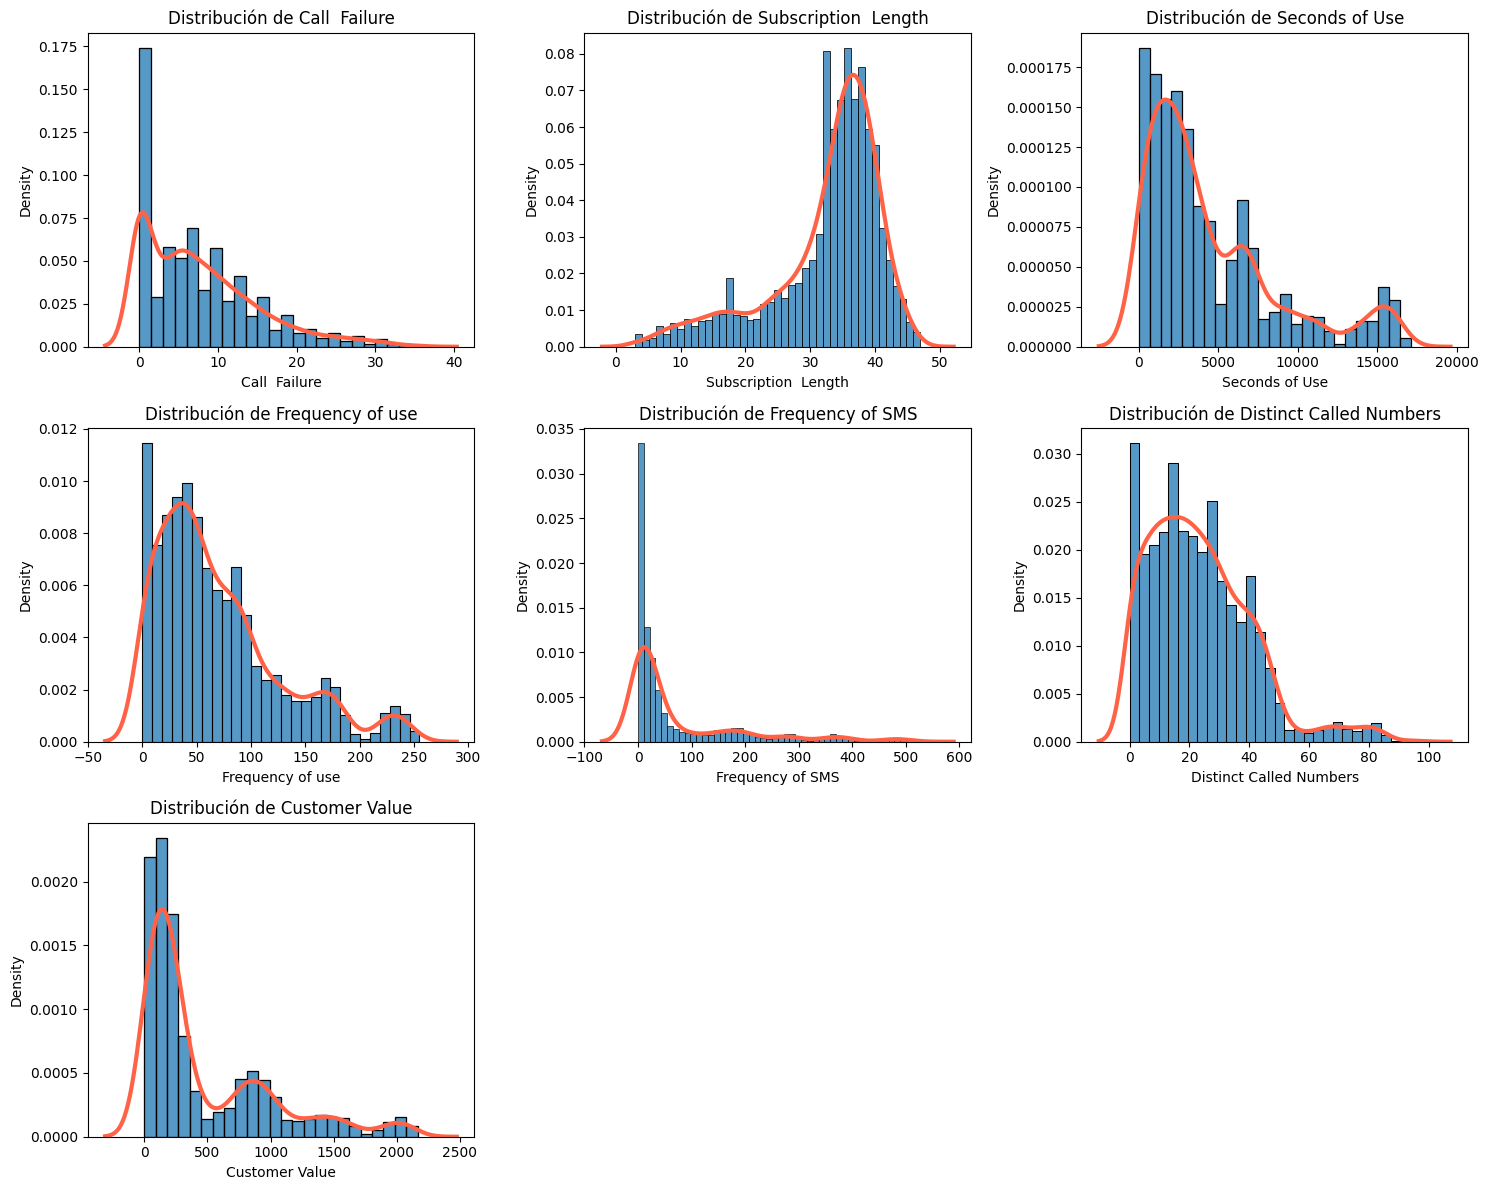

In [13]:
plot_hist(df, variables_cuantitativas)

> - **Aproximadamente normales / simétricas**: No existen variables que distribuyan de forma normal.
>
> - **Fuertemente asimétricas a la derecha**: Suscription Lenght.
>
> - **Fuertemente asimétricas a la derecha**:
Call Failure, Seconds of Use, Frecuency of use, Frecuency of SMS, Distict Called Numbers y Customer Value tienen mucha masa en valores bajos-medios (cercanos a cero) y valores extremos altos (posibles outliers/influencia fuerte).


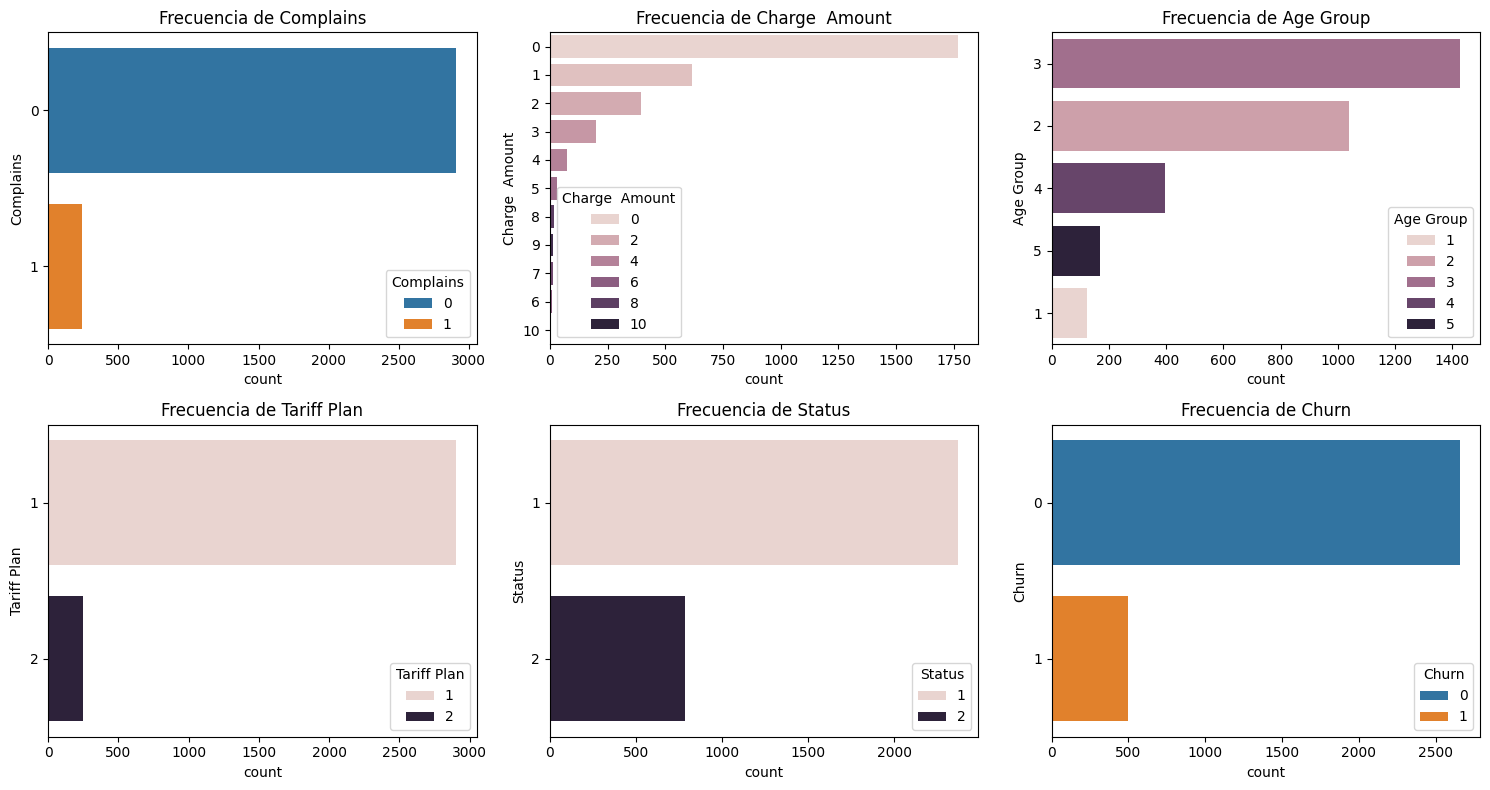

In [16]:
plot_count(df, variables_cualitativas)

> - **Complaints**: Existen pocas quejas en general.
> - **Charge Amount**: La mayoria tiene un importe bajo.
> - **Age group**: Los clientes están concentrados en los grupos de edad media.
> - **Tariff plan**: La mayoria de los clientes tienen una tarifa de pago por uso.
> - **Status**: Existe una gran cantidad de clientes inactivos.
> - **Churn** (target): tiene la clase 1 desequilibrada, cancelación es muy bajo.

### Outliers

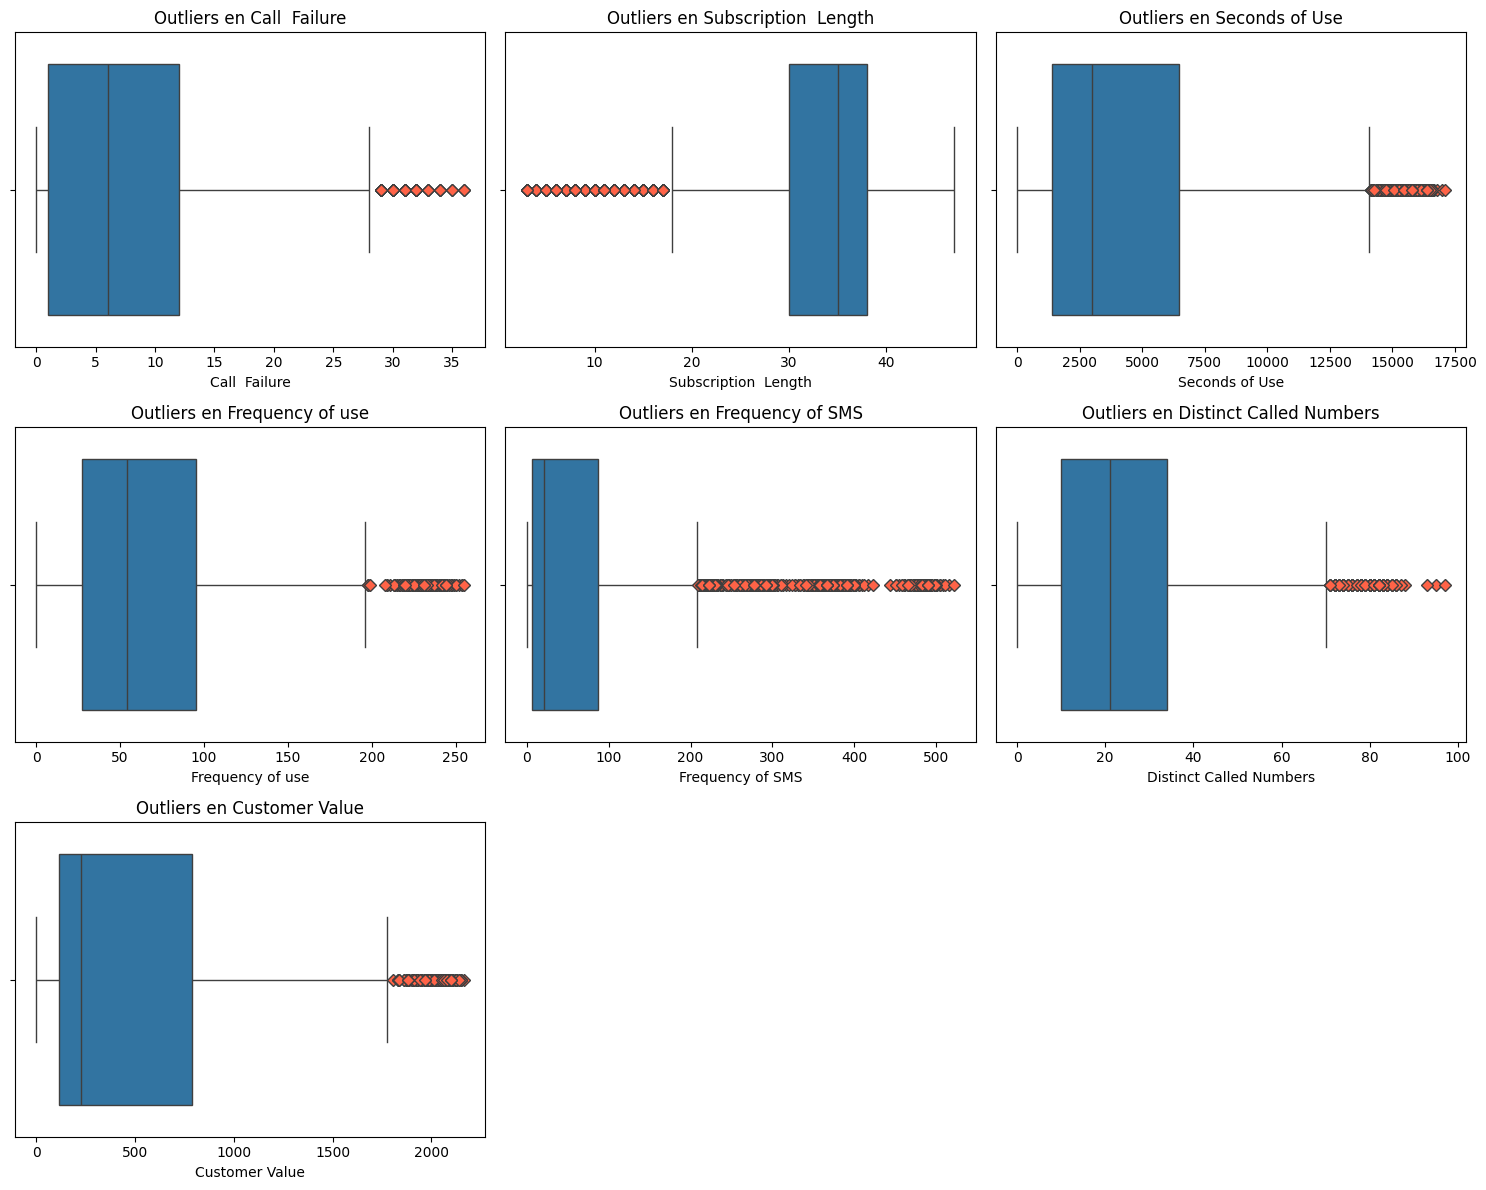

In [17]:
plot_outliers(df, variables_cuantitativas)

> Eliminar outliers

In [23]:
df = clean_outliers_percentiles(df, variables_cuantitativas, 0, 99.5)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3053 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call  Failure            3053 non-null   int64  
 1   Complains                3053 non-null   int64  
 2   Subscription  Length     3053 non-null   int64  
 3   Charge  Amount           3053 non-null   int64  
 4   Seconds of Use           3053 non-null   int64  
 5   Frequency of use         3053 non-null   int64  
 6   Frequency of SMS         3053 non-null   int64  
 7   Distinct Called Numbers  3053 non-null   int64  
 8   Age Group                3053 non-null   int64  
 9   Tariff Plan              3053 non-null   int64  
 10  Status                   3053 non-null   int64  
 11  Age                      3053 non-null   int64  
 12  Customer Value           3053 non-null   float64
 13  Churn                    3053 non-null   int64  
dtypes: float64(1), int64(13)
memo

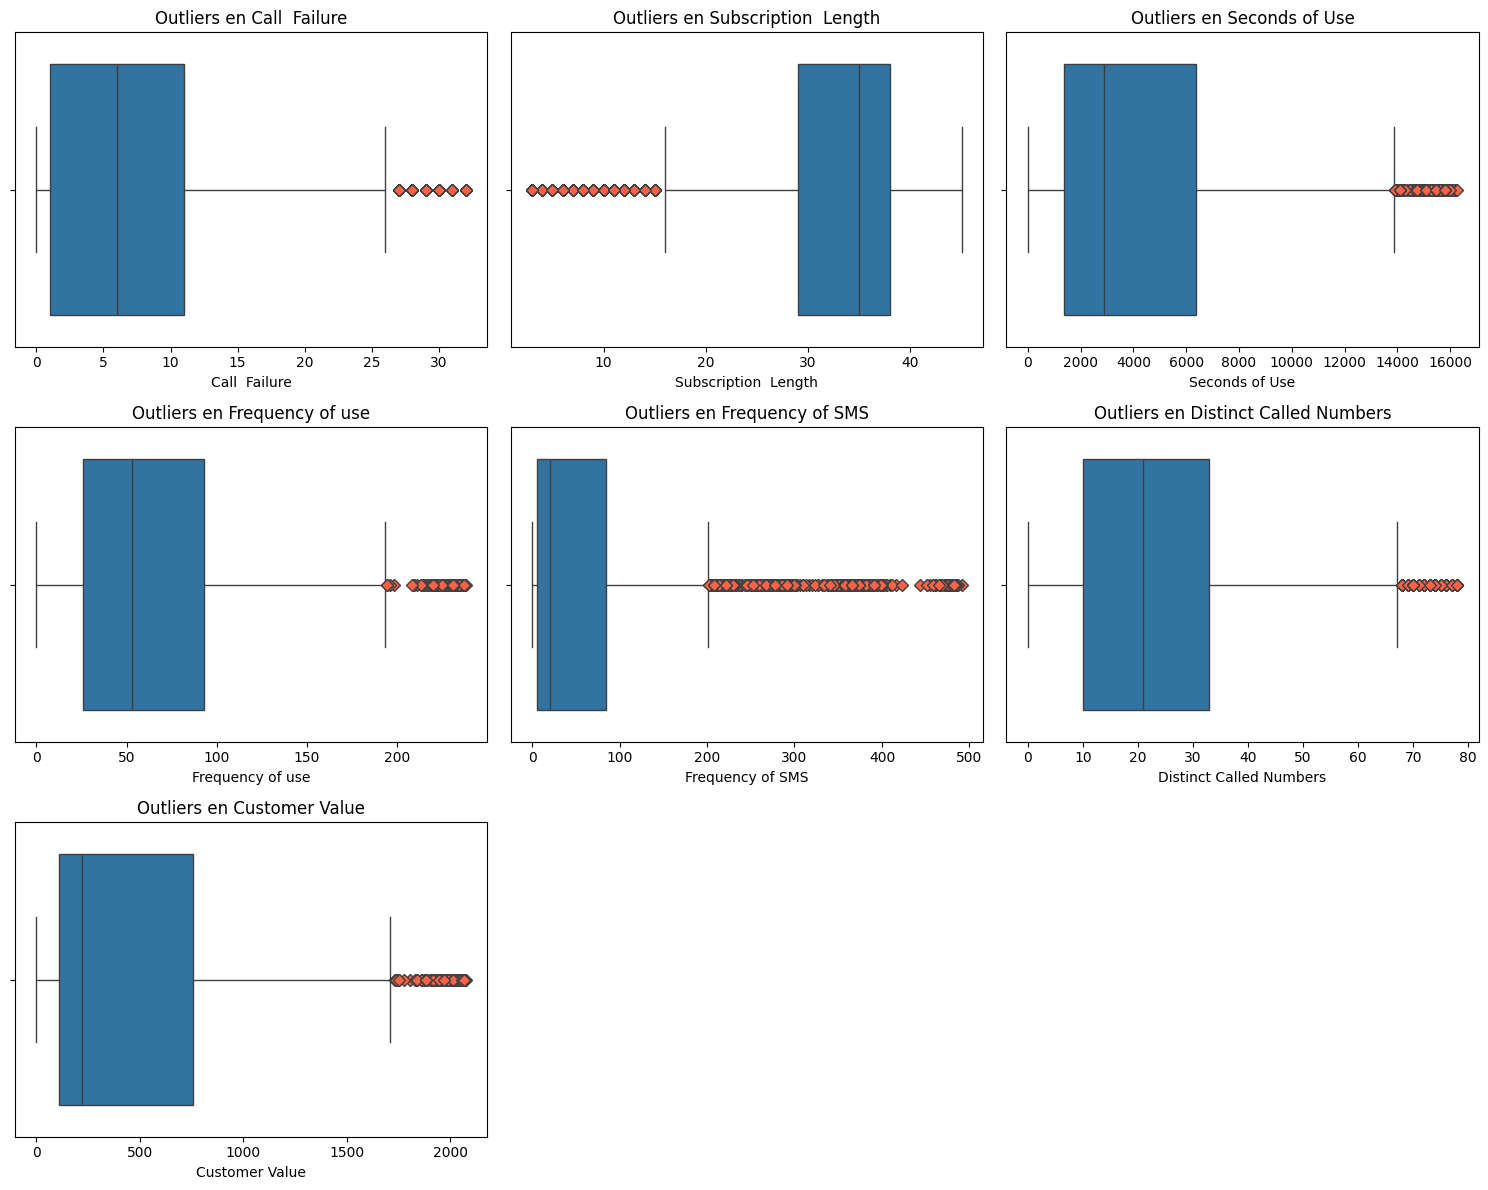

In [25]:
plot_outliers(df, variables_cuantitativas)

### Correlaciones

> Se calcula la correlación Spearman debido a que las variables en general NO distribuyen de forma normal

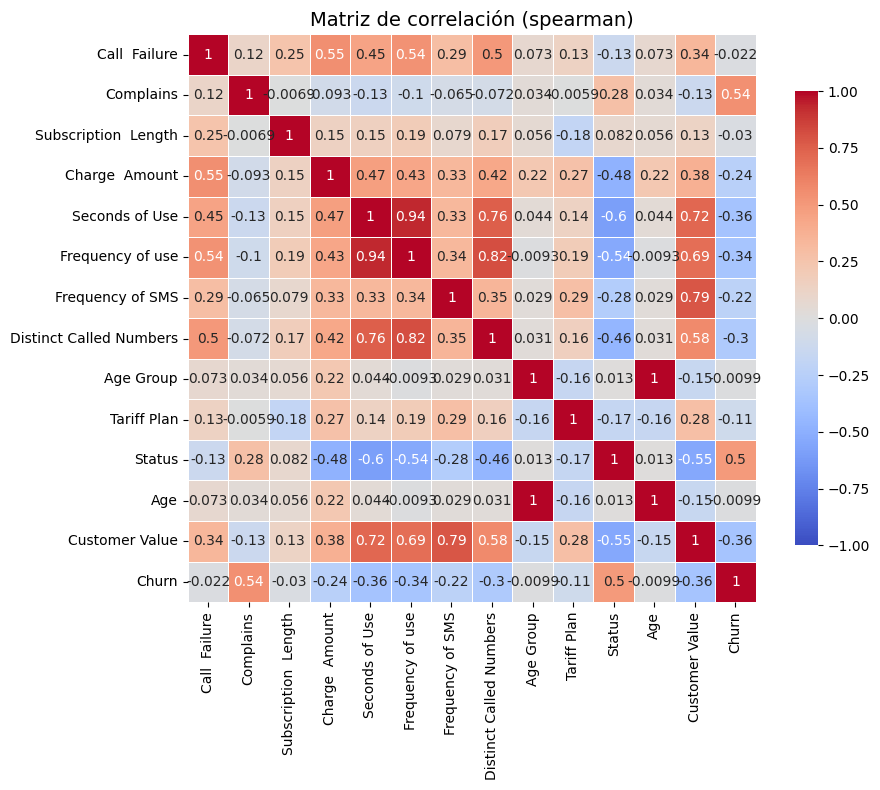

In [26]:
# Mostrar un gráfico con la matriz de correlación
plot_corr(df, method="spearman",
    figsize=(10, 8), annot=True)

> **Correlación**: Correlaciones más importantes con target (Pearson)
>
>- Mayor relación positiva (Churn):
>
>   - Complains (0.54): a más reclamos, mayor probabilidad de churn.
>
>   - Status (0.50): el estado del cliente está fuertemente asociado al churn (depende de cómo esté codificado, pero es una señal importante).
>
> - Relación negativa moderada (↓ uso/valor : ↑ Churn):
>
>   - Seconds of Use (-0.36), Frequency of use (-0.34), Distinct Called Numbers (-0.30), Customer Value (-0.36), Frequency of SMS (-0.22)
>
>
> **Conclusión**: Churn parece estar impulsado principalmente por insatisfacción (reclamos) y por condición/estado del cliente, y también por baja actividad/valor de uso (usuarios “fríos” tienen más churn).

## Subscription Length

Analiza la distribución de “Subscription Length” para cada clase (Churn),
describiendo si hay alguna incidencia de esta variable en la renuncia o no. Realiza
una estandarización de las variables regresoras

---

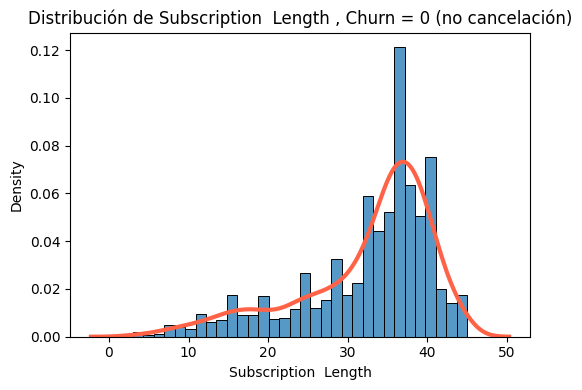

In [31]:
plot_hist(df[df['Churn'] == 0], ['Subscription  Length'], _title=", Churn = 0 (no cancelación)")

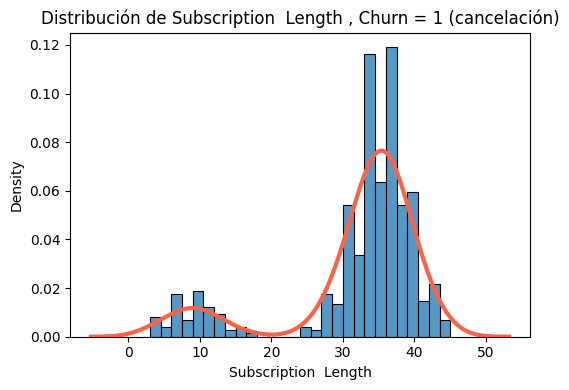

In [32]:
plot_hist(df[df['Churn'] == 1], ['Subscription  Length'], _title=", Churn = 1 (cancelación)")

> En ambas clases existe una masa de clientes concentrada de 30 y 45 meses. Sin embargo, aparece em Churn=1 una pequeña masa de clientes entre los meses 5 y 15. En conclusión la variable de Suscription Lenght no tiene insidencia importante en Churn (consecuente a los resultados de la correlación).

## 3. Balanceo

Muestra la frecuencia de cada clase y realiza un balanceo de clase usando SMOTE.
Divida el conjunto de datos en entrenamiento y test, considerando para este último
un 33%.


---

In [35]:
# Mostrar la frecuencia de cada clase de Churn
df['Churn'].value_counts()

,count
Churn,
0,2560
1,493


In [36]:
# Mostrar porcentaje de cada clase de Churn
df['Churn'].value_counts(normalize=True)*100

,proportion
Churn,
0,83.85
1,16.15


> Existen 83.85% clientes que no presentan cancelación y solo 16.15% de clientes que presentan cancelación.

In [37]:
target_col = 'Churn'
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

# Split (33% test, estratificado por clase)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.33,
    random_state=42,
    stratify=y
)

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


## 4. RandomForest

Entrene un modelo RandomForest con hiper parámetros por defecto, usando el
conjunto de entrenamiento anterior y muestra la métrica F1-Score para ambas
clases en el conjunto de test. Captura y muestra las siete características más
importantes detectadas por el modelo RandomForest.

---

In [39]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)


y_pred = rf.predict(X_test)

report = classification_report(y_test, y_pred, output_dict=True)
print("F1-score por clase (TEST):")
print(f"  Clase 0: {report['0']['f1-score']:.4f}")
print(f"  Clase 1: {report['1']['f1-score']:.4f}")

F1-score por clase (TEST):
  Clase 0: 0.9677
  Clase 1: 0.8421


In [40]:
# Top 7 características más importantes
importances = rf.feature_importances_

# Obtener nombres de columnas si X_train es DataFrame
if hasattr(X_train_res, "columns"):
    feature_names = np.array(X_train_res.columns)
else:
    feature_names = np.array([f"feature_{i}" for i in range(X_train_res.shape[1])])

top_idx = np.argsort(importances)[::-1][:7]

top_features = pd.DataFrame({
    "feature": feature_names[top_idx],
    "importance": importances[top_idx]
}).reset_index(drop=True)

print("\nTop 7 características más importantes (RandomForest):")
print(top_features)


Top 7 características más importantes (RandomForest):
                   feature  importance
0           Seconds of Use        0.16
1         Frequency of use        0.14
2                   Status        0.13
3           Customer Value        0.10
4     Subscription  Length        0.09
5         Frequency of SMS        0.08
6  Distinct Called Numbers        0.07


## 5. Nivel de importancia

Usando las siete características encontradas anteriormente, filtra el conjunto de
entrenamiento y entrena un modelo de red neuronal feedforward con sólo una capa
oculta. Para esto debes definir una función de activación adecuada, tanto para la
capa oculta como para la capa de salida, la cantidad de neuronas a usar, la tasa de
aprendizaje (learning_rate), y la cantidad de épocas deben ser ajustadas
manualmente. Como optimizador, utiliza el Descenso del Gradiente Estocástico. Los
ajustes manuales de los hiper parámetros deben ser tales que la métrica AUC sea
mayor al 90%. Muestra finalmente ROC y su AUC.


---

In [53]:
# Obtenemos la base de datos de las 7 caracteristicas obtenidas antes
top7 = top_features["feature"].tolist()

X_train_7 = X_train_res[top7].copy() if hasattr(X_train_res, "columns") else X_train_res[:, top7]
X_test_7  = X_test[top7].copy()  if hasattr(X_test, "columns")  else X_test[:, top7]

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_7, y_train_res, test_size=0.2, stratify=y_train_res, random_state=42
)

# Se escala la base de datos
scaler = StandardScaler()
X_tr_s  = scaler.fit_transform(X_tr)
X_val_s = scaler.transform(X_val)  # Conjunto de validación para obtener mejor modelo de red neuronal
X_test_s = scaler.transform(X_test_7)

y_tr = np.array(y_tr).astype("float32")
y_val = np.array(y_val).astype("float32")
y_test_np = np.array(y_test).astype("float32")

In [63]:
#Función para generar distintos modelos de redes neuronales

def build_model(n_hidden=32, learning_rate=0.01):
  model = Sequential([
      Input(shape=(X_tr_s.shape[1],)),
      Dense(n_hidden, activation="tanh"),     # capa oculta (tanh)
      Dense(1, activation="sigmoid")          # salida binaria
  ])

  opt = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
  model.compile(
      optimizer=opt,
      loss="mean_squared_error",
      metrics=[AUC(name="auc")]
  )
  return model

In [66]:
configs = [
  # (neuronas, learning_rate, epochs, batch_size)
  (7,  0.05, 100, 32),
  (7,  0.01,  100, 32),
  (14,  0.05, 100, 32),
  (14,  0.01,  100, 32),
  (20,  0.05, 100, 32),
  (20,  0.01, 100, 32)
]

best_auc = -1
best_cfg = None
best_model = None
best_history = None

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_auc", mode="max", patience=20, restore_best_weights=True
    )
]

for n_hidden, lr, epochs, bs in configs:
  tf.keras.backend.clear_session()
  model = build_model(n_hidden=n_hidden, learning_rate=lr)

  history = model.fit(
      X_tr_s, y_tr,
      validation_data=(X_val_s, y_val),
      epochs=epochs,
      batch_size=bs,
      verbose=0,
      callbacks=callbacks
  )

  # AUC validación
  val_proba = model.predict(X_val_s, verbose=0).ravel()
  auc_val = roc_auc_score(y_val, val_proba)

  print(f"Config: hidden={n_hidden}, lr={lr}, epochs={epochs}, bs={bs}  ->  AUC_val={auc_val:.4f}")

  if auc_val > best_auc:
    best_auc = auc_val
    best_cfg = (n_hidden, lr, epochs, bs)
    best_model = model
    best_history = history

print("\nMejor config:", best_cfg)
print("Mejor AUC (validación):", round(best_auc, 4))

Config: hidden=7, lr=0.05, epochs=100, bs=32  ->  AUC_val=0.9435
Config: hidden=7, lr=0.01, epochs=100, bs=32  ->  AUC_val=0.9118
Config: hidden=14, lr=0.05, epochs=100, bs=32  ->  AUC_val=0.9553
Config: hidden=14, lr=0.01, epochs=100, bs=32  ->  AUC_val=0.9306
Config: hidden=20, lr=0.05, epochs=100, bs=32  ->  AUC_val=0.9569
Config: hidden=20, lr=0.01, epochs=100, bs=32  ->  AUC_val=0.9216

Mejor config: (20, 0.05, 100, 32)
Mejor AUC (validación): 0.9569


AUC (TEST): 0.9493


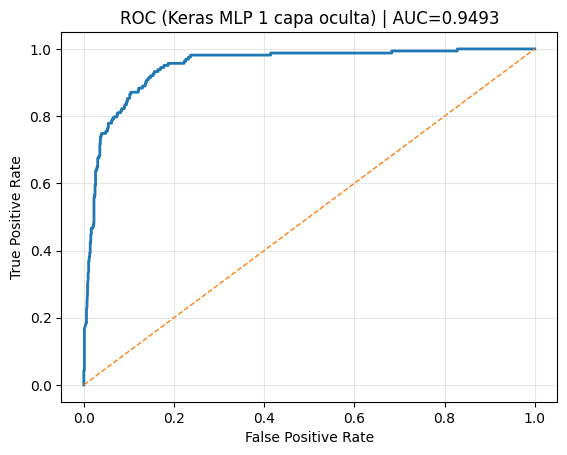

In [67]:
test_proba = best_model.predict(X_test_s, verbose=0).ravel()
auc_test = roc_auc_score(y_test_np, test_proba)
print("AUC (TEST):", round(auc_test, 4))

fpr, tpr, _ = roc_curve(y_test_np, test_proba)

plt.figure()
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC (Keras MLP 1 capa oculta) | AUC={auc_test:.4f}")
plt.grid(True, alpha=0.3)
plt.show()